In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [3]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

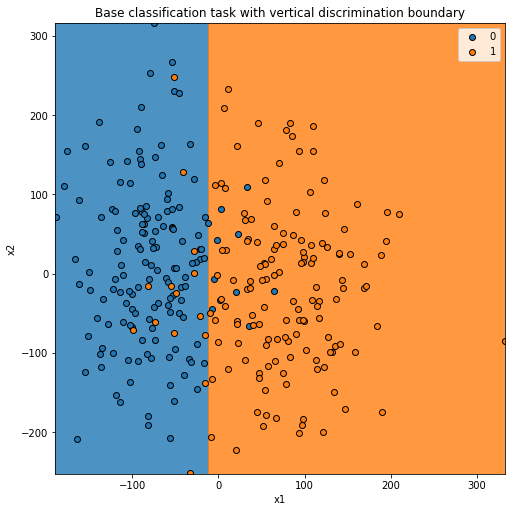

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with vertical discrimination boundary', feature_names,
                       predict=tree.predict, class_names=tree.classes_,
                       fig=fig, ax=ax)

In [5]:
clf_a = tree

In [6]:
from helper_models import ModifiedClassifier
class MyModifiedClassifier(ModifiedClassifier):
    def _preprocess(self, X):
        X2 = X.copy()
        X2[:, 0] += 25
        return X2
    
clf_b = MyModifiedClassifier(tree)
clf_b.fit(X, y)

MyModifiedClassifier(base_model=DecisionTreeClassifier(max_depth=1))

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

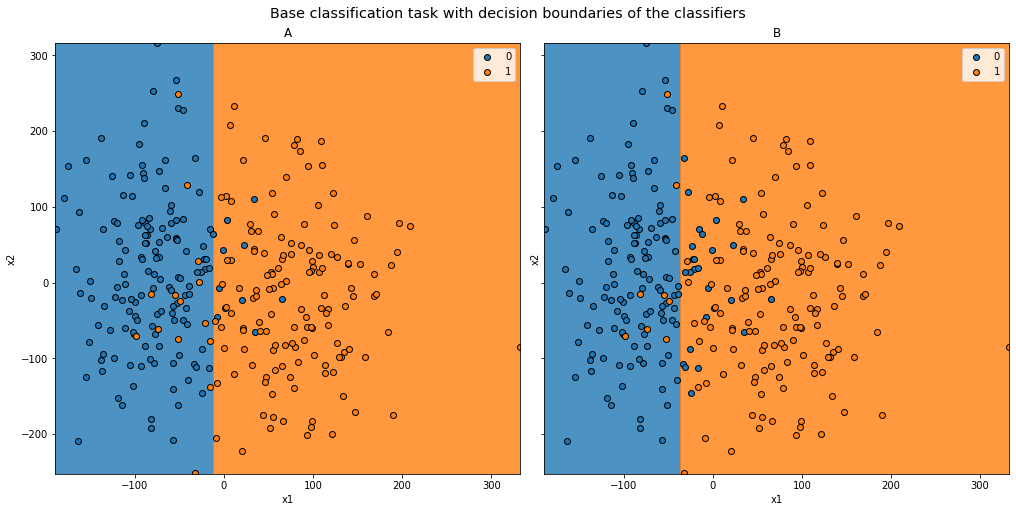

In [8]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

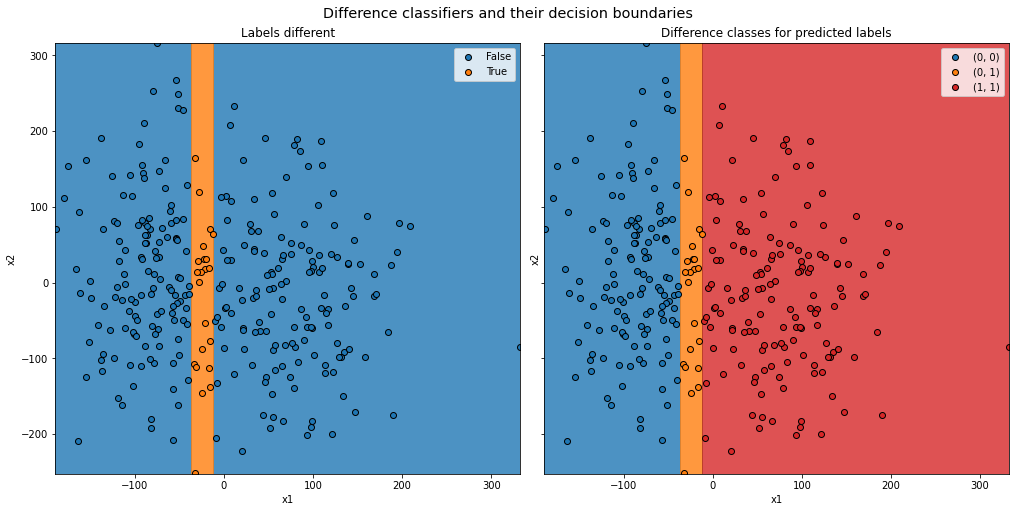

In [9]:
comparer.plot_decision_boundaries(X)

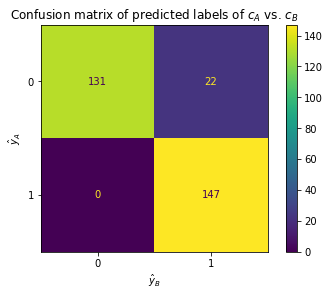

In [10]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [11]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.29 s, sys: 82.7 ms, total: 5.37 s
Wall time: 5.62 s


In [12]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## Traditional Approach

### Feature importance

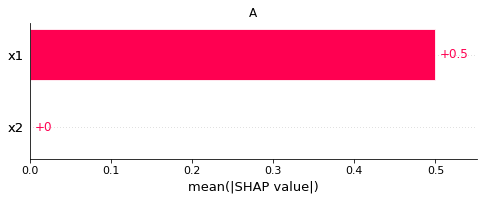

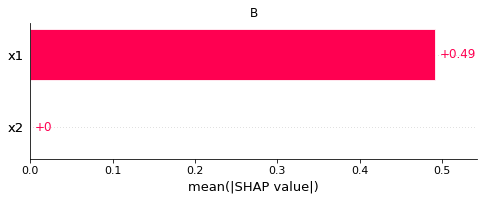

In [13]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])
plot_feature_importance_bar(explanations.indiv.labels.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.labels.B[:, :, 1], title='B', feature_order=feature_order)

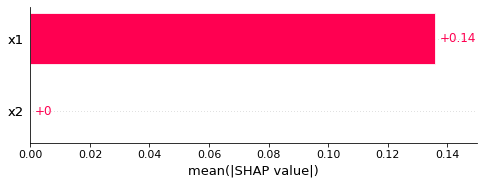

In [14]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

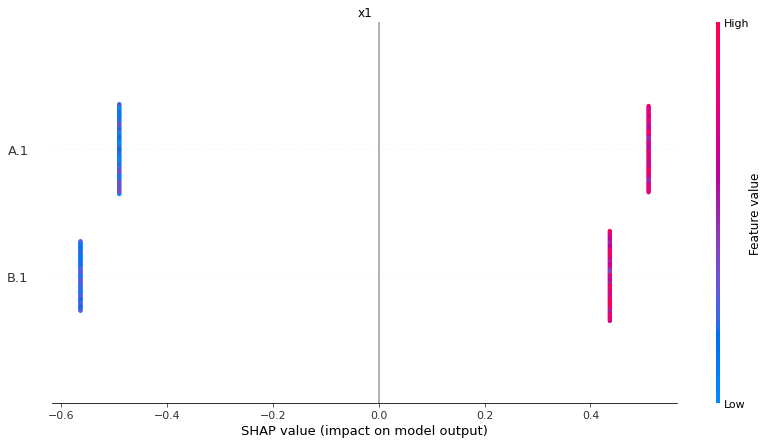

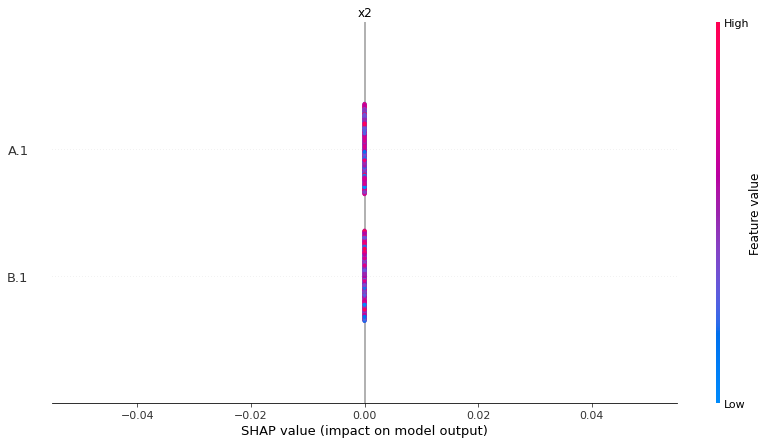

In [15]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Feature Effects

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


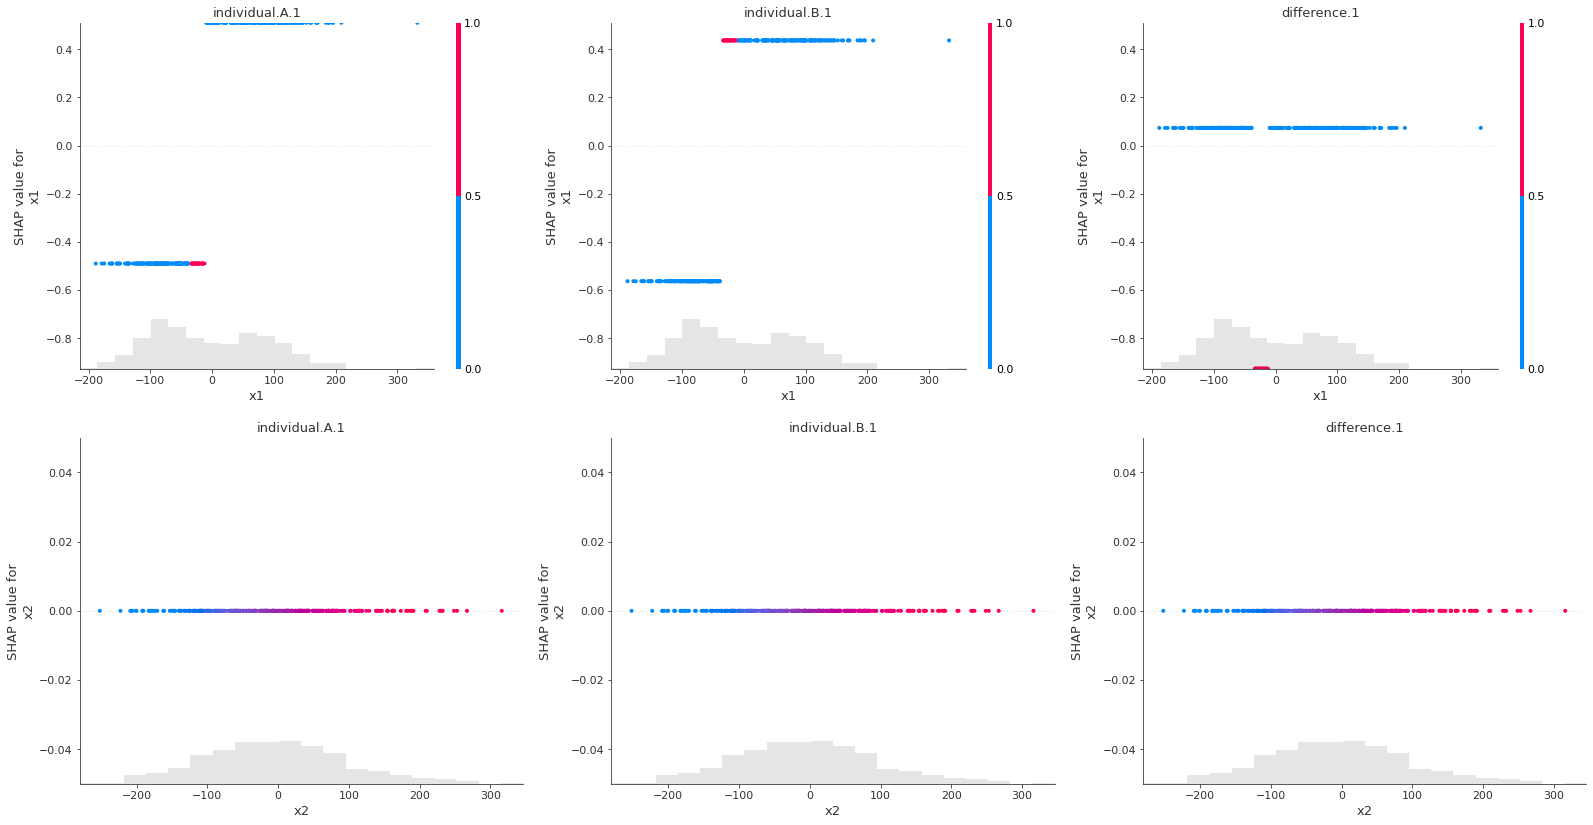

In [16]:
plot_feature_effects(merge_explanations(individual=explanations.indiv.labels[:, feature_order, 1],
                                        difference=explanations.indiv_diff.labels[:, feature_order, 1]),
                     color=is_pred_diff)

## Difference classifier explanations

### Feature importance

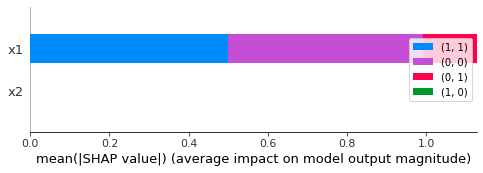

In [17]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

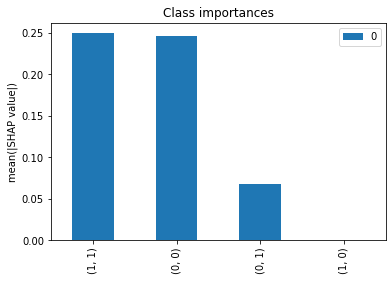

In [18]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

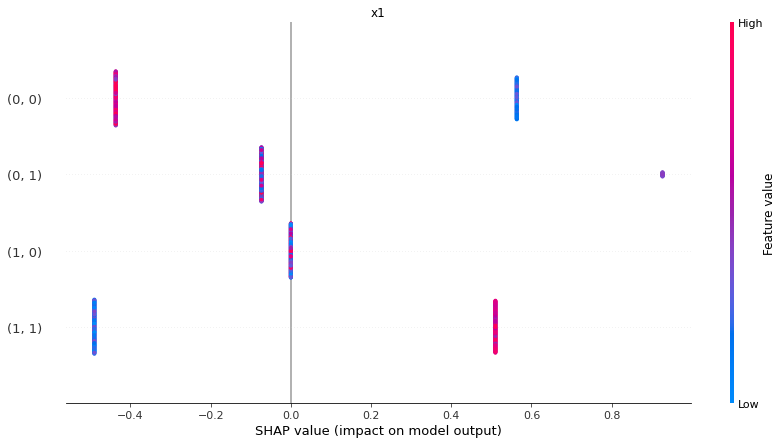

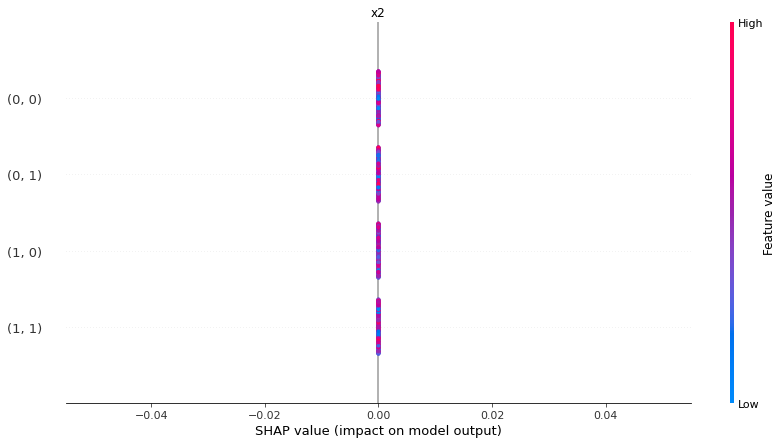

In [19]:
plot_feature_importance_scatter(explanations.mclass_diff.labels[:, feature_order])

### Feature effects

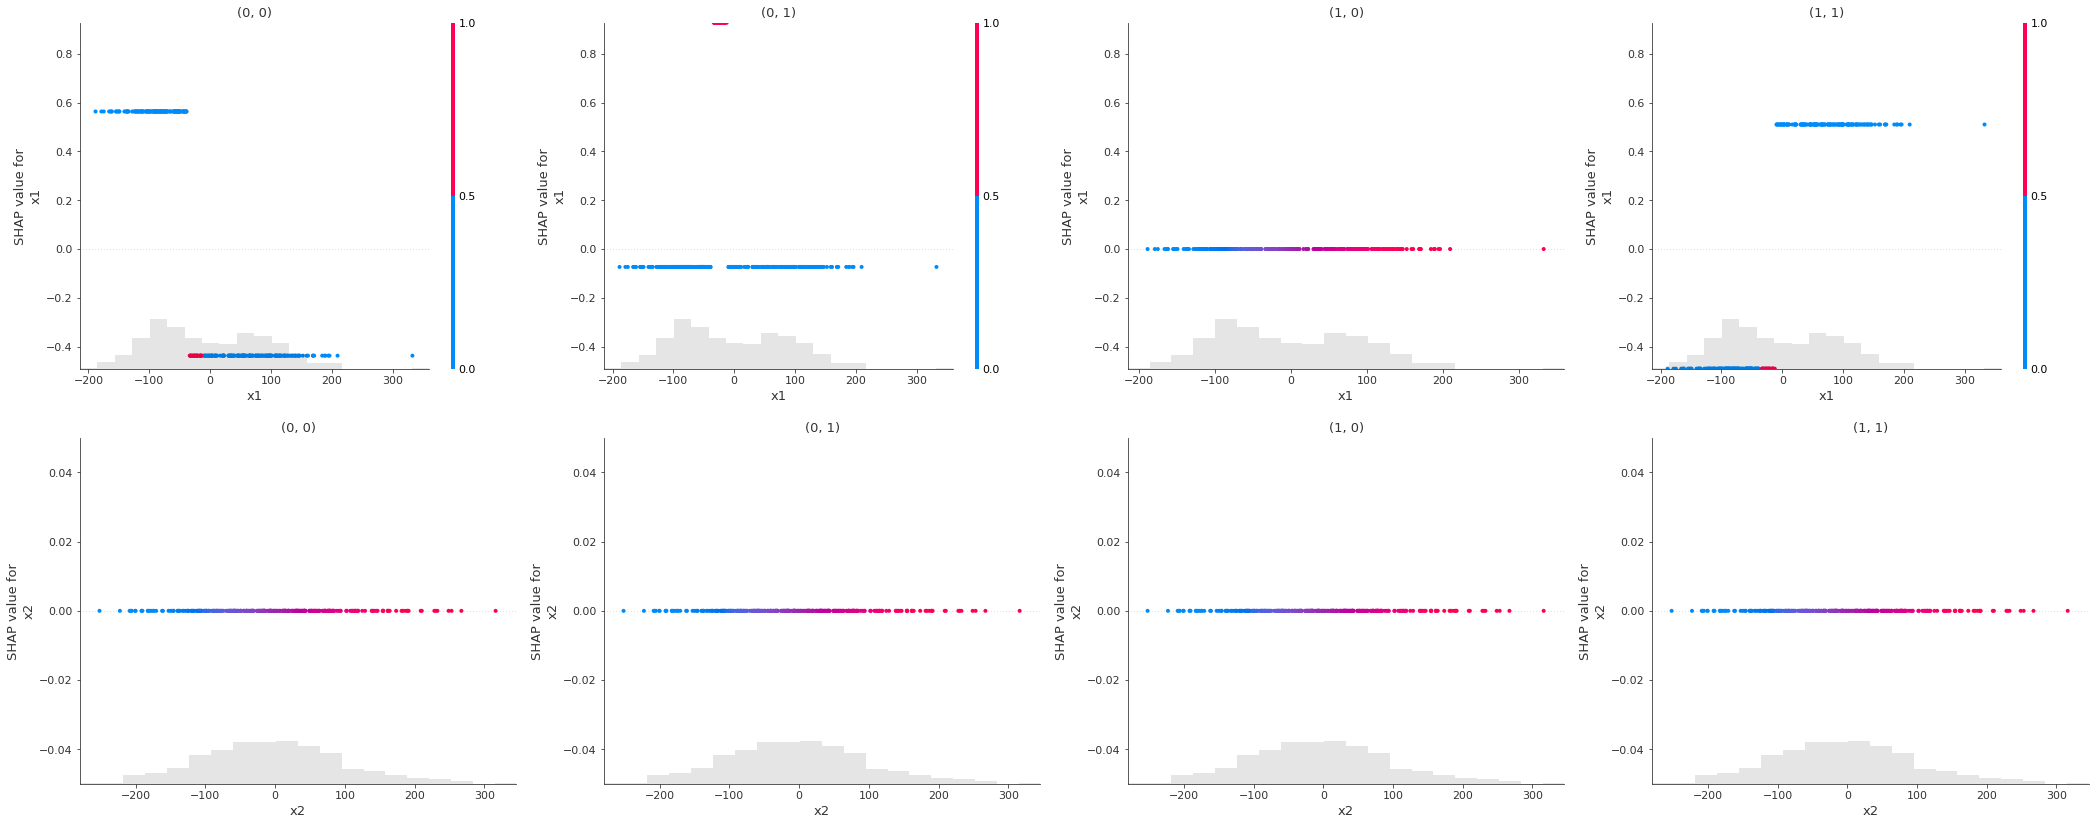

In [20]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

# Local Explanations

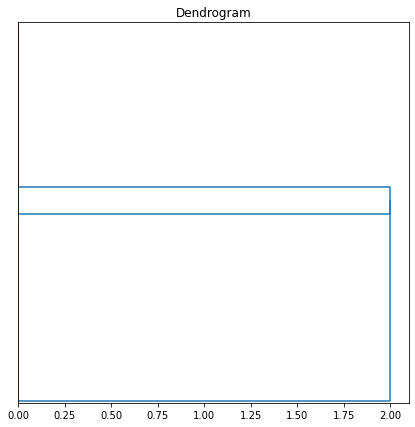

In [21]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

In [22]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=3)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,0,147
c2,0,22,0,0
c3,131,0,0,0


In [23]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,0,147
c2,0,22,0,0
c3,131,0,0,0
c4,0,0,0,0


In [24]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,131,22,0,147
c2,0,0,0,0


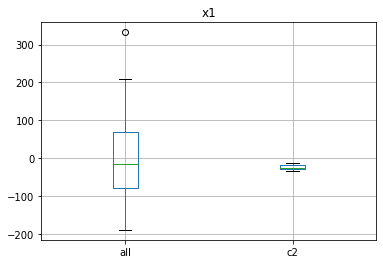

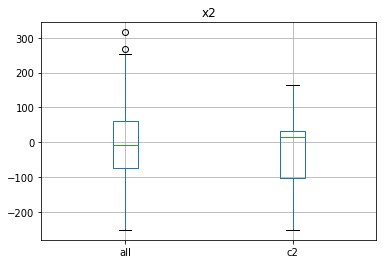

In [25]:
for feature_name in comparer.feature_names[feature_order]:
    df = pd.concat([pd.Series(explanations[:, feature_name].data)] +
                   [pd.Series(explanations_clustered.mclass_diff.labels.cohorts[cluster][:, feature_name].data)
                    for cluster in clusters_of_interest], axis=1)
    df.columns = ['all'] + clusters_of_interest.tolist()
    df.boxplot()
    plt.title(feature_name)
    plt.show()

## 1st Cluster

In [30]:
cluster = clusters_of_interest[0]
confusion_class = '(0, 1)'
shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

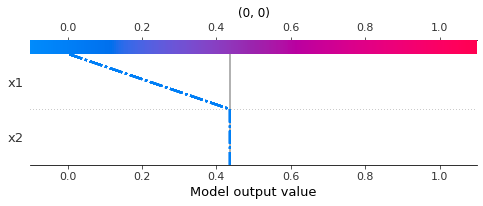

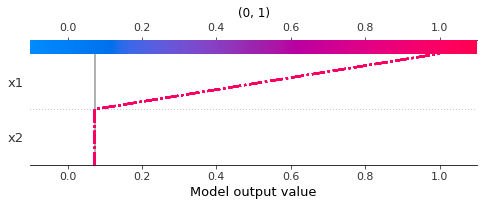

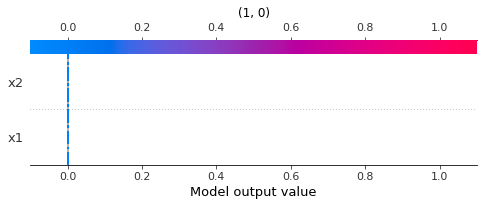

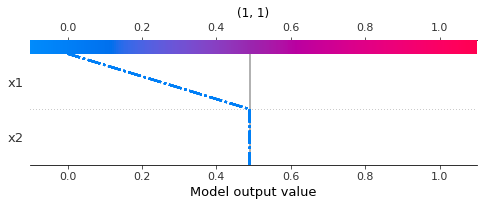

In [51]:
plot_decision(shap_values, highlight=instances_confused, xlim=(-0.1, 1.1))

### Feature importances

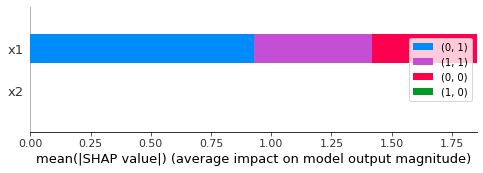

In [31]:
feature_order, feature_importances = calc_feature_order(shap_values)
plot_feature_importance_bar(shap_values)

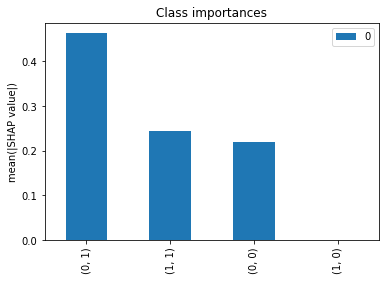

In [32]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

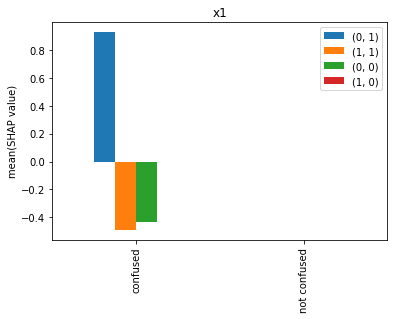

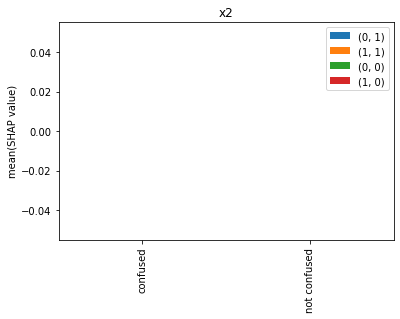

In [47]:
plot_feature_influence_comparison(shap_values, instances_confused, feature_order, class_order)

### Feature effects

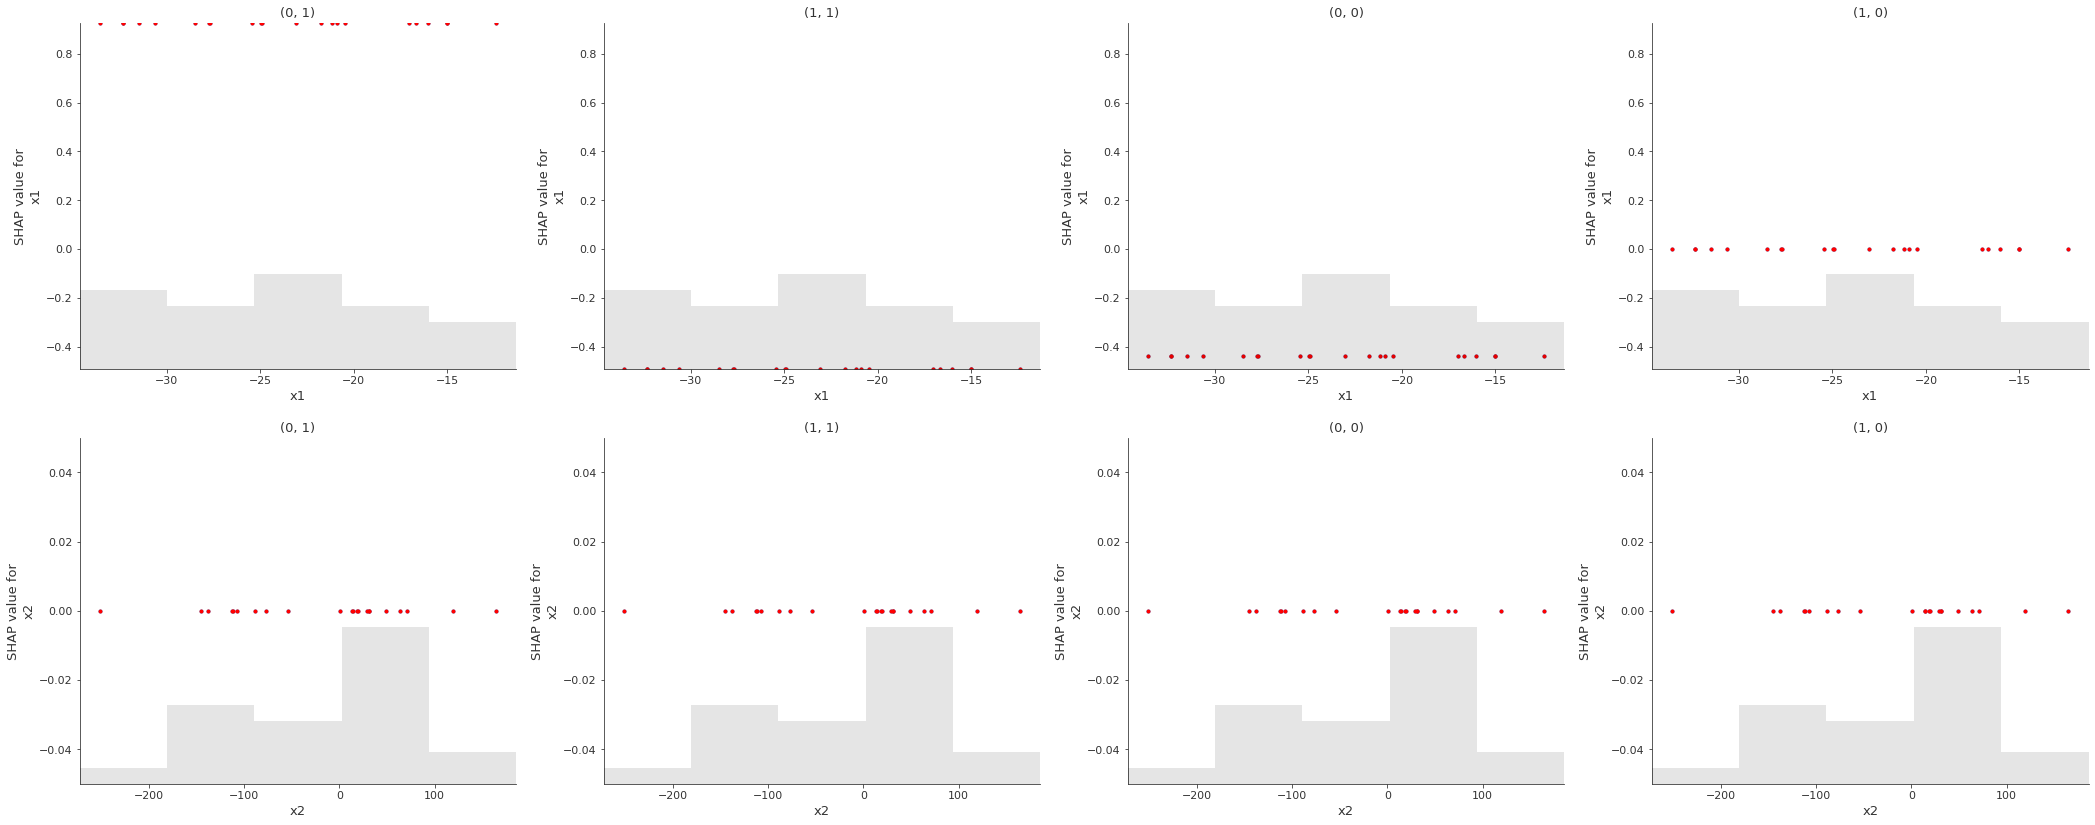

In [49]:
plot_feature_effects(shap_values[:, feature_order][:, :, class_order], highlight=instances_confused)

### diro2c

In [30]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
explanation = generate_diro2c_explanation(X, idx_explain, comparer, confusion_class)

CPU times: user 21.7 s, sys: 300 ms, total: 22 s
Wall time: 24.4 s


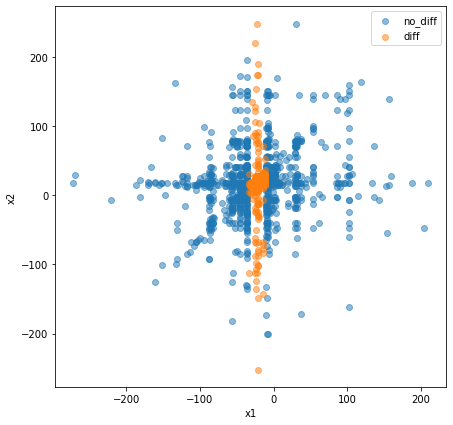

In [31]:
plot_diro2c_2d(explanation, 'x1', 'x2')

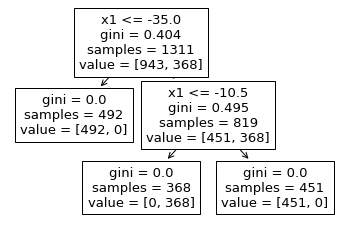

In [32]:
plot_diro2c_tree(explanation)